In [1]:
import h5py
import numpy as np
import time
import pandas as pd
import seaborn as sns
# 绘图库
import matplotlib.pyplot as plt



In [2]:
#选择要测试kpi sms=0 call=1 internet=2
kpi=0
if kpi==0:
    kpi_name='sms'
    kpi_maxdata=10119
elif kpi==1:
    kpi_name='call'
    kpi_maxdata=4435
else:
    kpi_name='internet'
    kpi_maxdata=40253

In [3]:



f = h5py.File('D:\library\Github\Innovative-practice\第三学期\convlstm\preddata\\testY0.7.h5', 'r')
f1=h5py.File(f'D:\library\Github\Innovative-practice\第三学期\convlstm\preddata\\testpred400_{kpi_name}0.7.h5', 'r')
data=f['testY']
data = data[:,40:60,40:60,kpi]
data=np.array(data)
data=np.reshape(data,(data.shape[0], data.shape[1], data.shape[2],1))
pread=f1['data']
pread=pread[:,40:60,40:60,:]
pread=np.array(pread)
f.close()
f1.close()
print(data.shape)
print(pread.shape)

data=data*kpi_maxdata
pread=pread*kpi_maxdata

(422, 20, 20, 1)
(422, 20, 20, 1)


In [4]:
#查看data第一维度的长度
print(len(data))
print(data[0,:,:,:].shape)

422
(20, 20, 1)


In [14]:
from scipy.stats import kstest
import pandas as pd
import numpy as np
def KsNormDetect(data):
    # 计算均值
    u = data.mean()
    # 计算标准差
    std = data.std()
    # 计算P值
    res=kstest(data, 'norm', (u, std))[1]
    # 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从。
    if res<=0.05:
        #print('该列数据服从正态分布------------')
        #print('均值为：%.3f，标准差为：%.3f' % (u, std))
        #print('------------------------------')
        return 1
    else:
        return 0



def OutlierDetection(data,ks_res):
    # 计算均值
    u =data.mean()
    # 计算标准差
    std = data.std()
    if ks_res==1:
        # 定义3σ法则识别异常值
        # 识别异常值
        error_y = [i for i in data if abs(i-u)> 3 * std]
        # 识别异常值的索引
        error_index = [i for i in range(len(data)) if abs(data[i]-u)> 3 * std]
        #error_y转变为一行int列表
        error_y = [int(i) for i in error_y]
        return error_y,error_index

    else:
        print('请先检测数据是否服从正态分布-----------')
        return [],[]





In [5]:
residual=abs(data-pread)
print(residual.shape)



(422, 20, 20, 1)


In [16]:
import matplotlib.pyplot as plt
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

for i in range(10):
    for j in range (10):
        data_p=data[:,i,j,:]
        pread_p=pread[:,i,j,:]
        residual_p=residual[:,i,j,:]
        ks_res=KsNormDetect(residual_p)
        error_y,error_index=OutlierDetection(residual_p, ks_res)
       
        plt.figure( figsize=(100,10) )
        plt.subplot(2,1,1)
        plt.plot(data_p)
        plt.plot(pread_p)
        #error_index用取出testY中的异常值
        plt.scatter(error_index,data_p[error_index],c='r',linewidths=25)
        plt.title(f"{kpi_name}测试集预测图{i*10+j}",fontsize=50)
        plt.legend(['testY',"testYPredict"],fontsize=50)
        plt.subplot(2,1,2)
        plt.plot(residual[:,i,j,:])
        plt.scatter(error_index,error_y,c='r',linewidths=25)
        plt.title(f"{kpi_name}测试集误差图{i*10+j}",fontsize=50)
        plt.savefig(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\convlstm\pred400\{kpi_name}\{kpi_name}测试集预测图{i*10+j}.png')
        plt.close()

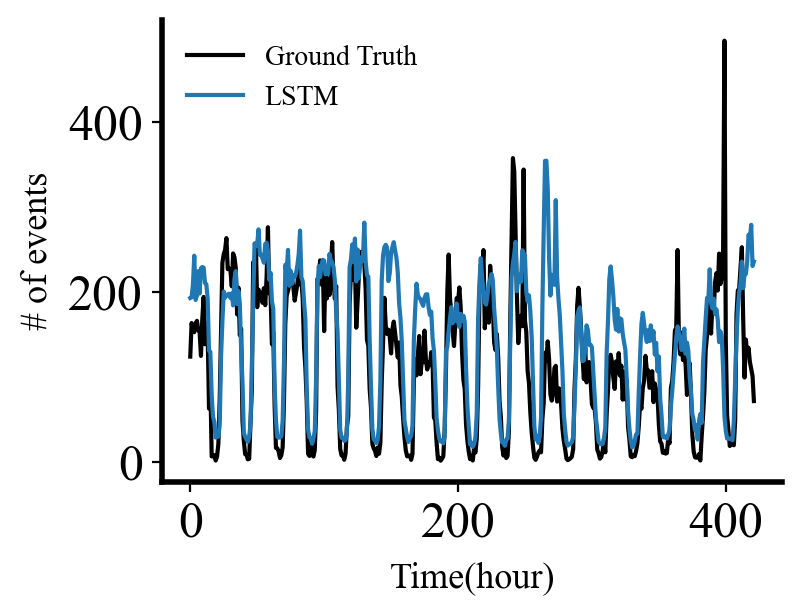

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
# 可视化绘制
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time(hour)', fontsize=13,labelpad=5)
ax.set_ylabel('# of events', fontsize=13,labelpad=5)

ax.plot(data[:,0,15,:],label='Ground Truth',color='black')
ax.plot(pread[:,0,15,:],label='LSTM')
ax.legend(fontsize=10,loc='upper left',frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


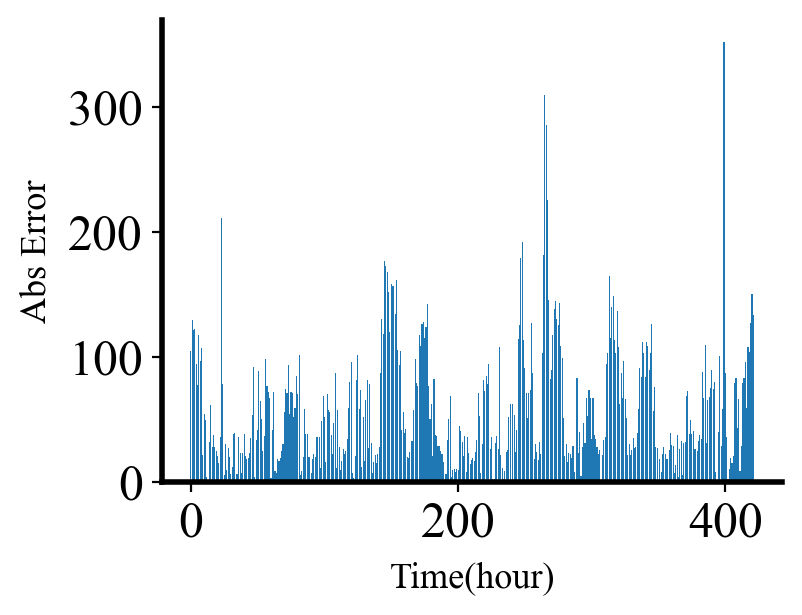

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
# 可视化绘制
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time(hour)', fontsize=13,labelpad=5)
ax.set_ylabel('Abs Error', fontsize=13,labelpad=5)
data1=(residual[:,10,10,:])
#data转换为一维数组
data1=data1.reshape(-1)
#绘制误差条形图
ax.bar(range(422),data1)
ax.legend(fontsize=10,loc='upper left',frameon=False)

In [9]:
from  sklearn import  metrics
import numpy as np

def GetRMSE(y_hat,y_test):
    sum = np.sqrt(metrics.mean_squared_error(y_test, y_hat))
    return  sum

def GetMAE(y_hat,y_test):
    sum = metrics.mean_absolute_error(y_test, y_hat)
    return  sum

def GetMAPE_Order(y_hat,y_test):
    #删除test_y 为0元素
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat,zero_index[0])
    y_test = np.delete(y_test,zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum
#计算R2
def GetR2(y_hat,y_test):
    sum = metrics.r2_score(y_test, y_hat)
    return sum

pread=pread.reshape(-1)
data=data.reshape(-1)
print(GetRMSE(pread,data))
print(GetMAE(pread,data))
print(GetMAPE_Order(pread,data))
print(GetR2(pread,data))



122.62884297666855
62.9206510062324
758.4723407788206
0.6542752998485568
